Starting with a Kalman using the camera and the motor commands only

In [54]:
import numpy as np
import math
import time
import random
import matplotlib.pyplot as plt

Next two steps depend on model only

In [2]:
def motModel(x, u, T1, r):
    g = np.array([0., 0., 0., 0., 0., 0.]) #just initializing a 2D array
    g[0] = (x[0] + T1*math.cos(x[4])*(u[0] + u[1])/2)
    g[1] = x[1] + T1*math.sin(x[4])*(u[0] + u[1])/2
    g[2] = math.cos(x[4])*(u[0] + u[1])/2
    g[3] = math.sin(x[4])*(u[0] + u[1])/2
    g[4] = x[4] + T1*(u[0] - u[1]) / (2*r)
    g[5] = (u[0] - u[1]) / (2*r)
    return g

In [3]:
def Gjacobian(theta, m1 ,m2, T1, r):
    #G = np.array([[0.,0.,0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.,0.,0.]])
    #the previous one was 6x8
    #i need 6x6
    G = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.]])
    G[0,0] = 1
    G[1,1] = 1
    G[0,4] = -T1*math.sin(theta)*(m1+m2)/2
    G[1,4] = T1*math.cos(theta)*(m1+m2)/2
    G[2,4] = -math.sin(theta)*(m1+m2)/2
    G[3,4] = math.cos(theta)*(m1+m2)/2
    G[4,4] = 1
    return G

Next two steps depend on measurements

In [4]:
def measModel(x,T1,r):
    h = np.array([0.,0.,0.])
    h[0] = x[0]
    h[1] = x[1]
    h[2] = x[4] #added for the camera angle
    return h

In [5]:
def Hjacobian(theta, T1, camState):
    H = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.]])
    H[0,0] = 1
    H[1,1] = 1
    H[2,4] = 1 #added for camera angle
    if camState == 'false':
        H[0,0] = 0
        H[1,1] = 0
        H[2,4] = 0 #added for camera angle
    return H

In [6]:
def kalmanFilter(mu_prev, sig_prev, u, measu, T1, r, R, Q, camState):
    
    #a priori estimations
    mu_est_a_priori = motModel(mu_prev,u,T1,r) #a priori estimation of position. mu_t = g(u,mu_t-1)
    
    theta = mu_est_a_priori[4]
    m1 = u[0]
    m2 = u[1]
    G = Gjacobian(theta,m1,m2,T1,r)
    sig_est_a_priori = (G @ sig_prev @ np.transpose(G)) + R
    
    #gain computation
    H = Hjacobian(theta,T1, camState)
    K = sig_est_a_priori @ np.transpose(H) @ np.linalg.inv((H @ sig_est_a_priori @np.transpose(H)) + Q)
    
    #measurement update
    mu_est_a_posteriori = mu_est_a_priori.reshape(-1,1) + (K@(measu - measModel(mu_prev,T1,r)).reshape(-1,1))
    sig_est_a_posteriori = (np.identity(6) - (K @ H)) @ sig_est_a_priori
    
    return mu_est_a_posteriori, sig_est_a_posteriori

/*----------------------------------------------------------------------------------------*/

J'ai les mesures de position de camera de Tanguy donc je peux essayer avec ça

In [45]:
meas = np.array([[184, 742], [181, 744], [184, 742], [184, 742], [184, 742], [184, 743], [184, 743], [184, 742], [184, 742], [184, 742], [184, 742], [184, 742], [184, 742], [181, 745], [184, 743], [184, 743], [184, 743], [184, 742], [184, 742], [184, 742], [184, 742], [184, 742], [184, 743], [185, 743], [185, 743], [185, 743], [184, 743], [184, 742], [184, 742], [183, 742], [185, 742], [185, 742], [186, 741], [182, 743], [186, 740], [186, 739], [186, 739], [186, 738], [187, 738], [183, 741], [189, 736], [189, 737], [190, 734], [190, 734], [191, 733], [192, 732], [192, 732], [193, 731], [193, 731], [190, 733], [194, 731], [191, 731], [195, 728], [195, 727], [195, 726], [196, 726], [197, 726], [195, 726], [198, 724], [196, 724], [196, 724], [199, 722], [200, 721], [200, 720], [200, 720], [202, 719], [203, 718], [203, 718], [203, 717], [204, 716], [205, 715], [205, 715], [205, 715], [206, 714], [206, 714], [207, 713], [204, 714], [208, 712], [208, 710], [210, 708], [207, 709], [210, 708], [211, 707], [211, 707], [211, 707], [210, 707], [211, 706], [213, 705], [210, 705], [212, 703], [215, 701], [216, 701], [217, 700], [218, 700], [214, 701], [218, 698], [218, 698], [219, 697], [219, 696], [220, 695], [220, 695], [220, 695], [222, 694], [222, 693], [219, 695], [223, 691], [224, 690], [220, 693], [220, 693], [226, 688], [225, 688], [227, 687], [227, 687], [227, 686], [228, 685], [225, 686], [230, 683], [230, 683], [230, 683], [232, 681], [232, 681], [232, 681], [232, 680], [233, 679], [233, 679], [234, 678], [235, 677], [235, 676], [232, 679], [236, 675], [237, 674], [238, 673], [238, 673], [238, 672], [239, 672], [239, 671], [240, 671], [241, 671], [242, 668], [242, 668], [243, 667], [243, 666], [243, 665], [244, 664], [244, 664], [244, 664], [245, 664], [246, 663], [243, 663], [247, 662], [248, 660], [248, 660], [248, 659], [248, 658], [249, 658], [248, 657], [248, 657], [248, 657], [249, 656], [249, 655], [247, 656], [249, 654], [250, 653], [250, 652], [250, 652], [250, 651], [250, 650], [251, 650], [251, 650], [250, 649], [251, 649], [251, 648], [251, 646], [251, 647], [251, 644], [251, 644], [251, 643], [252, 642], [251, 642], [251, 641], [251, 641], [252, 640], [252, 640], [252, 639], [251, 638],[252, 638], [252, 636], [251, 636], [252, 635], [252, 634], [251, 634], [252, 633], [252, 633], [252, 632], [251, 632], [251, 631], [251, 630], [250, 630], [251, 629], [250, 629], [250, 628], [250, 627], [250, 627], [249, 626], [249, 626], [249, 625], [249, 625], [249, 623], [249, 623], [249, 622], [248, 621], [248, 620], [248, 619], [248, 619], [248, 618], [248, 618], [248, 618], [248, 617], [247, 616], [247, 615], [247, 615], [247, 614], [246, 613], [246, 612], [246, 612], [245, 611], [245, 610], [245, 610], [245, 610], [244, 610], [244, 609], [243, 608], [243, 608], [243, 607], [242, 606], [242, 605], [242, 605], [241, 604], [241, 604], [240, 603], [240, 603], [240, 603], [240, 602], [240, 602], [239, 601], [239, 601], [238, 600], [237, 599], [237, 599], [236, 599], [236, 597], [236, 598], [236, 598], [235, 596], [235, 596], [234, 596], [233, 596], [233, 595], [232, 594], [232, 594], [232, 594], [231, 593], [231, 592], [230, 592], [230, 592], [230, 592], [229, 591], [229, 591], [228, 591], [228, 590], [227, 589], [226, 589], [227, 588], [225, 588], [226, 588], [225, 587], [225, 587], [224, 587], [224, 586], [224, 585], [223, 585], [223, 584], [222, 583], [222, 583], [222, 582], [221, 582], [221, 581], [221, 580], [221, 580], [220, 580], [220, 579], [220, 579], [219, 578], [218, 578], [218, 577], [217, 577], [218, 576], [217, 575], [216, 575], [216, 574], [216, 574], [216, 574], [215, 573], [215, 573], [214, 572], [214, 572], [213, 571], [213, 570], [213, 570], [212, 569], [212, 568], [212, 568], [212, 568], [211, 568], [211, 567], [211, 566], [210, 566],[210, 566], [209, 564], [208, 564], [208, 564], [208, 563], [208, 563], [207, 562], [207, 562], [207, 561], [206, 561], [206, 560], [206, 560], [206, 559], [205, 558], [204, 558], [204, 557], [203, 557], [203, 556], [203, 556], [203, 556], [202, 555], [202, 555], [202, 555], [201, 554], [201, 553], [200, 552], [199, 551], [199, 551], [199, 551], [199, 550], [198, 550], [198, 550], [198, 549], [197, 549], [197, 548], [197, 547], [196, 547], [195, 545], [195, 545], [195, 544], [194, 545], [194, 545], [194, 543], [194, 543], [194, 543], [193, 543], [192, 542], [193, 541], [192, 541], [191, 540], [190, 539], [190, 539], [191, 538], [189, 538], [188, 538], [188, 538], [190, 536], [189, 536], [188, 536], [188, 535], [188, 535], [187, 533], [186, 533], [186, 533], [185, 532], [185, 531], [185, 531], [185, 531], [184, 530], [184, 529], [184, 529], [183, 529], [183, 528], [182, 527], [182, 526], [181, 526], [181, 525], [181, 524], [180, 524], [180, 524], [180, 523], [180, 523], [180, 522], [180, 521], [180, 520], [179, 519], [179, 519], [179, 518], [179, 517], [179, 516], [178, 515], [178, 515], [178, 515], [178, 514], [178, 513], [178, 513], [178, 512], [178, 511], [178, 510], [177, 509], [177, 509], [178, 508], [178, 507], [178, 507], [177, 506], [178, 505], [177, 505], [177, 504], [177, 503], [177, 502], [177, 501], [177, 501], [177, 500], [177, 499], [177, 498], [177, 498], [177, 498], [178, 497], [178, 496], [177, 495], [178, 495], [178, 493], [178, 493], [178, 492], [178, 492], [178, 490], [178, 490], [178, 490], [178, 490], [178, 488], [178,488], [178, 487], [178, 487], [179, 486], [179, 485], [180, 483], [179, 483], [180, 482], [179, 482], [179, 482], [180, 481], [180, 480], [180, 480], [181, 479], [181, 478], [181, 478], [181, 477], [182, 476], [181, 475], [182, 475], [182, 474], [182, 474], [182, 474], [183, 473], [183, 472], [184, 472], [184, 471], [184, 470], [184, 470], [185, 468], [185, 468], [185, 467], [186, 467], [186, 467], [187, 466], [186, 465], [187, 465], [187, 464], [188, 464], [189, 463], [189, 462], [189, 462], [190, 460], [190, 460], [190, 460], [190, 460], [191, 459], [191, 459], [192, 459], [192, 458], [192, 457], [193, 456], [194, 456], [194, 456], [196, 454], [195, 455], [196, 454], [196, 454], [196, 453], [197, 452], [197, 452], [197, 452], [198, 451], [199, 451], [200, 450], [200, 449], [200, 449], [201, 448], [201, 447], [201, 447], [202, 446], [203, 445], [203, 445], [204, 444], [205, 443], [205, 442], [205, 441], [206, 440], [206, 440], [207, 439], [208, 438], [208, 438], [208, 438], [208, 437], [209, 436], [209, 435], [210, 434], [211, 434], [212, 432], [213, 432], [213, 431], [214, 430], [214, 429], [214, 429], [214, 429], [214, 428], [215, 426], [215, 426], [216, 426], [217, 425], [218, 423], [218, 423], [218, 422], [218, 421], [219, 420], [219, 420], [220, 420], [221, 419], [221, 419], [222, 418], [222, 417], [223, 415], [223, 415], [224, 414], [225, 413], [225, 412], [226, 412], [226, 412], [226, 411], [227, 410], [226, 410], [227, 409], [228, 408], [229, 407], [230, 406], [230, 405], [230, 404], [231, 404], [231, 403], [231, 403], [232, 402], [232, 402], [233, 401], [233, 400], [234, 400], [235, 398], [235, 397], [236, 396], [237, 395], [237, 395], [237, 394], [237, 394], [238, 393], [238, 393], [239, 392], [240, 391], [240, 390], [241, 388], [241, 388], [242, 387], [242, 386], [243, 386], [244, 385], [244, 385], [244, 384], [244, 383], [244, 383], [245, 382], [246, 381], [247, 380], [248, 379], [248, 378], [248, 378], [248, 377], [249, 376], [249, 376], [250, 375], [250, 374], [251, 374], [252, 373], [252, 372], [253, 371], [253, 370], [253, 370], [254, 369], [255, 368], [256, 367], [256, 367], [256, 367], [256, 366], [257, 365], [257, 364], [257, 363], [259, 362], [259, 362], [259, 362], [259, 362], [259, 362], [259, 361], [259, 361], [259, 361], [259, 361], [259, 361], [259, 362], [259, 362], [259, 362], [259, 362]])

Du coup il faut aussi que je mette à jour les commandes du thymio

In [46]:
old_u = np.array([[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],
[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],
[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],
[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],[10,100],
[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],
[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],
[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],
[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],[50,50],
[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],
[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],
[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],
[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],[100,10],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],
[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75],[75,75]])

In [47]:
CamAngle = np.array([-0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.89568455, -0.9063691 ,
       -0.91705365, -0.92773821, -0.93842276, -0.94910731, -0.95979186,
       -0.97047641, -0.98116096, -0.99184551, -1.00253006, -1.01321462,
       -1.02389917, -1.03458372, -1.04526827, -1.05595282, -1.06663737,
       -1.07732192, -1.08800648, -1.09869103, -1.10937558, -1.12006013,
       -1.13074468, -1.14142923, -1.15211378, -1.16279833, -1.17348289,
       -1.18416744, -1.19485199, -1.20553654, -1.21622109, -1.22690564,
       -1.23759019, -1.24827475, -1.2589593 , -1.26964385, -1.2803284 ,
       -1.29101295, -1.3016975 , -1.31238205, -1.3230666 , -1.33375116,
       -1.34443571, -1.35512026, -1.36580481, -1.37648936, -1.38717391,
       -1.39785846, -1.40854302, -1.41922757, -1.42991212, -1.44059667,
       -1.45128122, -1.46196577, -1.47265032, -1.48333488, -1.49401943,
       -1.50470398, -1.51538853, -1.52607308, -1.53675763, -1.54744218,
       -1.55812673, -1.56881129, -1.57949584, -1.59018039, -1.60086494,
       -1.61154949, -1.62223404, -1.63291859, -1.64360315, -1.6542877 ,
       -1.66497225, -1.6756568 , -1.68634135, -1.6970259 , -1.70771045,
       -1.718395  , -1.72907956, -1.73976411, -1.75044866, -1.76113321,
       -1.77181776, -1.78250231, -1.79318686, -1.80387142, -1.81455597,
       -1.82524052, -1.83592507, -1.84660962, -1.85729417, -1.86797872,
       -1.87866327, -1.88934783, -1.90003238, -1.91071693, -1.92140148,
       -1.93208603, -1.94277058, -1.95345513, -1.96413969, -1.97482424,
       -1.98550879, -1.99619334, -2.00687789, -2.01756244, -2.02824699,
       -2.03893154, -2.0496161 , -2.06030065, -2.0709852 , -2.08166975,
       -2.0923543 , -2.10303885, -2.1137234 , -2.12440796, -2.13509251,
       -2.14577706, -2.15646161, -2.16714616, -2.17783071, -2.18851526,
       -2.19919981, -2.20988437, -2.22056892, -2.23125347, -2.24193802,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.25262257,
       -2.25262257, -2.25262257, -2.25262257, -2.25262257, -2.24193802,
       -2.23125347, -2.22056892, -2.20988437, -2.19919981, -2.18851526,
       -2.17783071, -2.16714616, -2.15646161, -2.14577706, -2.13509251,
       -2.12440796, -2.1137234 , -2.10303885, -2.0923543 , -2.08166975,
       -2.0709852 , -2.06030065, -2.0496161 , -2.03893154, -2.02824699,
       -2.01756244, -2.00687789, -1.99619334, -1.98550879, -1.97482424,
       -1.96413969, -1.95345513, -1.94277058, -1.93208603, -1.92140148,
       -1.91071693, -1.90003238, -1.88934783, -1.87866327, -1.86797872,
       -1.85729417, -1.84660962, -1.83592507, -1.82524052, -1.81455597,
       -1.80387142, -1.79318686, -1.78250231, -1.77181776, -1.76113321,
       -1.75044866, -1.73976411, -1.72907956, -1.718395  , -1.70771045,
       -1.6970259 , -1.68634135, -1.6756568 , -1.66497225, -1.6542877 ,
       -1.64360315, -1.63291859, -1.62223404, -1.61154949, -1.60086494,
       -1.59018039, -1.57949584, -1.56881129, -1.55812673, -1.54744218,
       -1.53675763, -1.52607308, -1.51538853, -1.50470398, -1.49401943,
       -1.48333488, -1.47265032, -1.46196577, -1.45128122, -1.44059667,
       -1.42991212, -1.41922757, -1.40854302, -1.39785846, -1.38717391,
       -1.37648936, -1.36580481, -1.35512026, -1.34443571, -1.33375116,
       -1.3230666 , -1.31238205, -1.3016975 , -1.29101295, -1.2803284 ,
       -1.26964385, -1.2589593 , -1.24827475, -1.23759019, -1.22690564,
       -1.21622109, -1.20553654, -1.19485199, -1.18416744, -1.17348289,
       -1.16279833, -1.15211378, -1.14142923, -1.13074468, -1.12006013,
       -1.10937558, -1.09869103, -1.08800648, -1.07732192, -1.06663737,
       -1.05595282, -1.04526827, -1.03458372, -1.02389917, -1.01321462,
       -1.00253006, -0.99184551, -0.98116096, -0.97047641, -0.95979186,
       -0.94910731, -0.93842276, -0.92773821, -0.91705365, -0.9063691 ,
       -0.89568455, -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ,
       -0.885     , -0.885     , -0.885     , -0.885     , -0.885     ])

In [58]:
#Convert speed commands in mm/s
speed_conv = 0.33478260869565216
u = speed_conv*old_u
#J'essaie avec des valeurs au bol...
mu_init = np.array([0.,0.,0.,0.,CamAngle[1],0.]) #inital state at zero
sig_init = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.]])
T1 = 1/30 #33Hz
r = 47 #mm
#uncertainty on state
R = np.array([[0.01,0.,0.,0.,0.,0.],[0.,0.01,0.,0.,0.,0.],[0.,0.,0.01,0.,0.,0.],[0.,0.,0.,0.01,0.,0.],[0.,0.,0.,0.,0.01,0.],[0.,0.,0.,0.,0.,0.01]])
#uncertainty on measurement
Q = np.array([[0.01,0.,0.],[0.,0.01,0.],[0.,0.,0.01]])

x_pos_kal = np.zeros(len(meas))
y_pos_kal = np.zeros(len(meas))
x_pos_cam = np.zeros(len(meas))
y_pos_cam = np.zeros(len(meas))
error_x = np.zeros(len(meas))
error_y = np.zeros(len(meas))

move_range = 100

hide_camera = 'true'
camState = 'true' #do not change this one here
endKal = 1/30
startKal = 0

time step 6647.0634665
0.0
time step 0.00046750000001338776
0.0
time step 0.00024850000045262277
0.0
time step 0.0002586999999039108
0.0
time step 0.00029799999992974335
0.0
time step 0.0002592999999251333
0.0
time step 0.000387600000067323
0.0
time step 0.0002647000001161359
0.0
time step 0.0001351000000795466
0.0
time step 0.00012140000035287812
0.0
time step 0.0001170999994428712
0.0
time step 0.0012833999999202206
0.0
time step 0.0002235000001746812
0.0
time step 0.00036559999989549397
0.0
time step 0.00018679999993764795
0.0
time step 0.0002248999999210355
0.0
time step 0.00027630000022327295
0.0
time step 0.0001421999995727674
0.0
time step 0.00013179999950807542
0.0
time step 0.0002731000004132511
0.0
time step 0.00030730000071343966
0.0
time step 0.0002936000000772765
0.0
time step 0.000452199999926961
0.0
time step 0.0002623999998832005
0.0
time step 0.00028169999950478086
0.0
time step 0.0003040000001419685
0.0
time step 0.0002457999999023741
0.0
time step 0.00013730000046052

time step 0.0005689999998139683
0.0
time step 0.00022569999964616727
0.0
time step 0.0002749999994193786
0.0
time step 0.00017910000042320462
0.0
time step 0.0002044000002570101
0.0
time step 0.00021800000013172394
0.0
time step 0.0003053999998883228
0.0
time step 0.00047760000052221585
0.0
time step 0.0002750000003288733
0.0
time step 0.00019130000055156415
0.0
time step 0.00014259999989008065
0.0
time step 0.00014430000010179356
0.0
time step 0.0003878999996231869
0.0
time step 0.0003010000000358559
0.0
time step 0.0003027000002475688
0.0
time step 0.0003419999993639067
0.0
time step 0.000158200000441866
0.0
time step 0.00017410000054951524
0.0
time step 0.00015690000054746633
0.0
time step 0.00035370000023249304
0.0
time step 0.0003195999997842591
0.0
time step 0.0003494000002319808
0.0
time step 0.000351300000147603
0.0
time step 0.00045450000015989644
0.0
time step 0.0003544999999576248
0.0
time step 0.000425100000029488
0.0
time step 0.00033600000006117625
0.0
time step 0.0005447

<function matplotlib.pyplot.show(*args, **kw)>

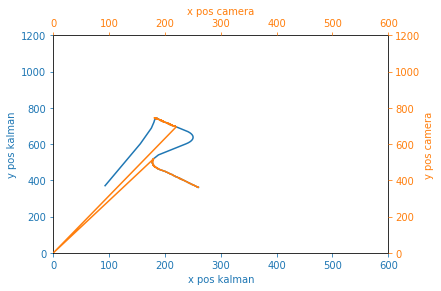

In [59]:
mu_prev = mu_init
sig_prev = sig_init

for i in range(len(meas)):
    endKal = time.perf_counter() #Added to count time steps
    Ttest = (endKal - startKal) #Added to count time steps
    startKal = time.perf_counter() #Added to count time steps
    print('time step', Ttest)
    print(angle*180/math.pi)
    (mu,sig) = kalmanFilter(mu_prev, sig_prev, u[i], np.append(meas[i],CamAngle[i]), T1, r, R, Q, camState)
    mu_prev = np.concatenate(np.transpose(mu))
    sig_prev = sig
    x_pos_kal[i] = mu_prev[0]
    y_pos_kal[i] = mu_prev[1]
    x_pos_cam[i] = meas[i][0]
    y_pos_cam[i] = meas[i][1]
    error_x[i] = (meas[i][0]-mu_prev[0])
    error_y[i] = (meas[i][1]-mu_prev[1])
    if hide_camera == 'true' and i > 100 and i<400:
        meas[i+1] = [0.,0.]
        camState = 'false'
    if hide_camera == 'true' and i == 400:
        camState = 'true'

print('measured x position', meas[i][0])
print('estimated x position', mu_prev[0])
print('measured y position', meas[i][1])
print('estimated y position', mu_prev[1])
print('maximum x error', max(error_x))
print('maximum y error', max(error_y))

fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on = False)

ax.plot(x_pos_kal, y_pos_kal, color="C0")
ax.set_xlabel("x pos kalman", color="C0")
ax.set_ylabel("y pos kalman", color="C0")
ax.tick_params(axis='x', colors="C0") #change la couleur des axes
ax.tick_params(axis='y', colors="C0")
ax.set_ylim([0,1200])
ax.set_xlim([0,600])

ax2.plot(x_pos_cam, y_pos_cam, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel("x pos camera", color="C1")
ax2.set_ylabel("y pos camera", color="C1")
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
ax2.set_ylim([0,1200])
ax2.set_xlim([0,600])

plt.show